In [1]:
     # ⚠️ to check and maybe fix
# Extra: Generate requirements file
#!pip install pipreqs

# Use one of these two to generate the file, check which one works
#!pipreqs . --force
#!pip freeze > requirements.txt

# Check the file
# Check the generated file
#with open('requirements.txt', 'r') as file:
#    print(file.read())

# If it's generated empty, check installed packages
#pip list
# and then run one of the two generators.

In [2]:
#!pip freeze > requirements.txt

# ⚠️ [S] DELTA Portfolio Task 3: Natural language processing

🔷 The following jupyter notebook is the computational essay required for the subjet Delta. <br>
The goal is to perform a sentiment analysis on a database composed of tweets about an specific topic , alongside the necessary previous steps for it's application.<br>
Submitted by: <u>Sebastian Guardia (Student ID:640621)</u>

Your task is to perform sentiment analysis using a sentiment dictionary, an RNN model, a pre-trained Transformer and a fine-tuned Transformer. The data is separated into a train set of 1500 tweets and a test set of 500 tweets
**The structure of the notebook is as follows:**
1. Libraries and dataset loading.
2. Partitioning and scaling the dataset. 
3. Definition of dataset structure. 
4. Simple RNN Model.
5. LSTM Model.
6. Plotting predictions.
7. Conclusion.

For every section there is a cell with the necessary libraries 

## Data Preprocessing

### Databases import and overview

In [7]:
import pandas as pd

# Import dataframes
train_df = pd.read_parquet('btc_tweets_train.parquet.gzip')
test_df = pd.read_parquet('btc_tweets_test.parquet.gzip')

#Index resetting
train_df = train_df.reset_index()
test_df = test_df.reset_index()

# First look
train_df.head()

,tweet ID,hashtags,content,username,user_displayname,sentiment
0,1641579121972236290,"[Bitcoin, Bitcoin, BTC, Bitcoin, BTC, SHIB, HO...","$Bitcoin TO $100,000 SOONER THAN YOU THINK‼️💯🙏...",BezosCrypto,SHIB Bezos,True
1,1641579176171016194,"[Bitcoin, bitcoinordinals, crypto]",Alright I have my rares. Who else is grabbing ...,spartantc81,SpartanTC,True
2,1641579486071390208,"[BTC, SHIB, HOGE, SAITAMA, BNB, DOGE, ETH, Bab...","Bitcoin (BTC) Targets Over $100,000 as This Im...",BezosCrypto,SHIB Bezos,True
3,1641579537103302656,[BTC],📢 Xverse Web-based pool is live:\n\n•Update @x...,godfred_xcuz,Algorithm.btc,True
4,1641579588399804418,[Bitcoin],"Yesterday, a Bitcoin projection was displayed ...",goddess81oo,she is lucky,True


In [8]:
# Get information of the data base
def df_info(df):
    return df.shape, df.info(), df.isnull().sum().sum()

df_info(train_df)
df_info(test_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet ID          1500 non-null   int64 
 1   hashtags          1500 non-null   object
 2   content           1500 non-null   object
 3   username          1500 non-null   object
 4   user_displayname  1500 non-null   object
 5   sentiment         1500 non-null   bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 60.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet ID          500 non-null    int64 
 1   hashtags          500 non-null    object
 2   content           500 non-null    object
 3   username          500 non-null    object
 4   user_displayname  500 non-null    object
 5   sentiment         500 non-null    b

((500, 6), None, 0)

In [9]:
# Check for class imbalance in training set
train_df['sentiment'].value_counts()

sentiment
True     1220
False     280
Name: count, dtype: int64

In [10]:
# Check for class imbalance in test set
test_df['sentiment'].value_counts()

sentiment
True     404
False     96
Name: count, dtype: int64

In [11]:
# Drop unnecessary columns
train_df = train_df.drop(['tweet ID', 'user_displayname', 'hashtags', 'username'], axis=1)
test_df = test_df.drop(['tweet ID', 'user_displayname', 'hashtags', 'username'], axis=1)

In [12]:
# Snapshot of the training dataframe we will be working with
train_df.head(3)

,content,sentiment
0,"$Bitcoin TO $100,000 SOONER THAN YOU THINK‼️💯🙏...",True
1,Alright I have my rares. Who else is grabbing ...,True
2,"Bitcoin (BTC) Targets Over $100,000 as This Im...",True


### Text preparation for analysis

🔷 The following class has been specifically created to appropriately prepare the text for each model, as each model requires specific data treatment.<br>
It contains several possible types of treatments: <br>  The class provides methods to clean, preprocess, and balance the dataset, preparing it for modeling <br> The class is intended to automate the preprocessing of text data, such as cleaning, removing unwanted content, handling class imbalance, and preparing the data for further analysis or machine learning models.
* common tasks in the preparation of textual data for analysis

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords
import re
import emoji
from urllib.parse import urlparse
from collections import Counter
from imblearn.over_sampling import SMOTE
from bs4 import BeautifulSoup


class DataPreprocessor:
    def __init__(self, df, content_column):
        """
        Initialize the DataPreprocessor class with the DataFrame and column of interest.

        Parameters:
        - df: pd.DataFrame
            The DataFrame containing the dataset.
            
        - content_column: str
            The name of the column containing the text content to analyze.
        """
        
        self.df = df
        self.content_column = content_column
    
    def remove_similar_content(self, similarity_threshold=0.75):
        """
        Removes samples with similar content based on cosine similarity.

        Parameters:
        - similarity_threshold: float (default=0.75)
            The threshold for cosine similarity above which samples are considered similar.
        """
        tfidf = TfidfVectorizer(stop_words='english')
        tfidf_matrix = tfidf.fit_transform(self.df[self.content_column])
        cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

        indices_to_remove = set()

        for i in range(len(cosine_sim)):
            for j in range(i + 1, len(cosine_sim)):
                if cosine_sim[i, j] > similarity_threshold:
                    indices_to_remove.add(i)
                    indices_to_remove.add(j)

        self.df = self.df.drop(index=indices_to_remove).reset_index(drop=True)
        return self.df

    def remove_hashtags(self, top_n=30, replace_with=None):
        """
        Remove non-whitelisted hashtags from the tweet, retaining only the top N most frequent hashtags.

        Parameters:
        - top_n: int (default=30)
            The number of most frequent hashtags to retain.
        - replace_with: str or None (default=None)
            If specified, replaces non-whitelisted hashtags with this string. If None, non-whitelisted hashtags are removed.
        """
        
        def extract_hashtags(tweet):
            """Extract all hashtags from the text."""
            return re.findall(r'#\w+', tweet)
        
        def create_hashtag_whitelist(top_n):
            """Create a whitelist of the top N most frequent hashtags."""
            hashtag_counts = Counter(hashtag for tweet in self.df[self.content_column] for hashtag in extract_hashtags(tweet))
            top_hashtags = set(hashtag for hashtag, _ in hashtag_counts.most_common(top_n))
            return top_hashtags
        
        # Create the whitelist of top N hashtags
        whitelist = create_hashtag_whitelist(top_n=top_n)
        
        def clean_hashtags(tweet):
            """Remove or replace non-whitelisted hashtags in the tweet."""
            hashtags = extract_hashtags(tweet)
            for hashtag in hashtags:
                if hashtag not in whitelist:
                    if replace_with:
                        tweet = re.sub(re.escape(hashtag), replace_with, tweet)
                    else:
                        tweet = re.sub(re.escape(hashtag), '', tweet)
            return tweet.strip()  # Remove leading/trailing whitespace
        
        self.df['cleaned_content'] = self.df[self.content_column].apply(clean_hashtags)
        return self.df

    def remove_emojis(self, emoji_whitelist=None, replace_with=None):
        """
        Retains only expression-related emojis from the whitelist or removes/replaces others.

        Parameters:
        - emoji_whitelist: list (optional)
            A list of emojis to retain. If None, a default list of expression-related emojis is used.
        - replace_with: str or None (optional)
            If specified, replaces non-whitelisted emojis with this string. If None, non-whitelisted emojis are removed.
        """
        if emoji_whitelist is None:
            emoji_whitelist = [
                "😀", "😃", "😄", "😁", "😆", "😅", "😂", "😊", "😇", "🙂",
                "🙃", "😉", "😌", "😍", "😘", "😗", "😙", "😚", "😋", "😜",
                "😝", "😛", "🤑", "😎", "🤓", "😏", "😒", "😞", "😔", "😟",
                "😕", "🙁", "☹️", "😣", "😖", "😫", "😩", "😢", "😭", "😤",
                "😠", "😡", "🤬", "🤯", "😳", "🥵", "🥶", "😱", "😨", "😰",
                "😥", "😓", "🤗", "🤔", "🤭", "🤫", "🤥", "😶", "😐", "😑",
                "😬", "🙄", "😯", "😦", "😧", "😮", "😲", "😴", "🤤", "😪",
                "😵", "🤐", "🥴", "🤢", "🤮", "🤧", "😷", "🤒", "🤕", "🤑",
                "🤠", "😈", "👿", "👹", "👺", "🤡", "💩", "👻", "💀", "☠️",
                "😺", "😸", "😹", "😻", "😼", "😽", "🙀", "😿", "😾"
            ]

        emoji_set = set(emoji.EMOJI_DATA.keys())

        def whitelist_and_replace_or_remove(tweet):
            """Retain whitelisted emojis and remove or replace non-whitelisted emojis."""
            result = []
            for char in tweet:
                if char in emoji_whitelist:
                    result.append(char)
                elif char in emoji_set:
                    if replace_with:
                        result.append(replace_with)
                else:
                    result.append(char)
            return ''.join(result)

        column_to_use = 'cleaned_content' if 'cleaned_content' in self.df.columns else self.content_column
        self.df['cleaned_content'] = self.df[column_to_use].apply(whitelist_and_replace_or_remove)
        return self.df
    
    def clean_text(self):
        """
        Cleans text data by removing punctuation, stopwords, and applying lemmatization.
        """
        stop_words = set(stopwords.words('english'))

        def clean(tweet):
            # Remove links
            tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
            # Removes HTML and whitespace from tweets
            if re.search(r'<.*?>', tweet):  # Check for HTML-like tags
                tweet = BeautifulSoup(tweet, 'html.parser').get_text()
            tweet = ' '.join(tweet.split())
            # Remove punctuation and numbers
            tweet = re.sub(r'[^a-zA-Z0-9\s$]', '', tweet)
            # Tokenize
            words = nltk.word_tokenize(tweet)
            # Remove stop words
            words = [word for word in words if word.lower() not in stop_words]
            # Lemmatize words
            lemmatizer = nltk.WordNetLemmatizer()
            words = [lemmatizer.lemmatize(word.lower()) for word in words]
            return ' '.join(words)
        
        self.df['cleaned_content'] = self.df[self.content_column].apply(clean)
        return self.df
 
    def preprocess(self, remove_similar_content=True, 
                   remove_hashtags = True,
                   remove_emojis = True,
                   clean_text=True):
        """
        Performs the full preprocessing pipeline.

        Parameters:
        - remove_similar_content: bool (default=True)
            Whether to remove similar content.
        - remove_hashtags: bool (default=True)
            Whether to remove hashtags from text.
        - remove_emojis: bool (default=True)
            Whether to remove specific emojis.    
        - clean_text: bool (default=True)
            Whether to clean text data.
        """
        if remove_similar_content:
            self.remove_similar_content()
        if remove_hashtags:
            self.remove_hashtags()      
        if remove_emojis:
            self.remove_emojis()
        if clean_text:
            self.clean_text()

        return self.df

🔷🔷🔷 Argumentation of the usage of: <br>
    * Cosine similarity: why did I decide to use 75 <br>
Why not to implement SMOTE in this case:
High-Dimensional, Sparse Data: Text data is typically high-dimensional (e.g., after vectorization with TF-IDF) and sparse, which can make SMOTE less effective. The synthetic samples generated by SMOTE may not make sense in the context of text data because the interpolated features might not correspond to realistic word combinations.
Sequential and Contextual Information: Text data often involves sequences of words where the order and context are important. SMOTE does not consider the sequence of words, so it may generate unrealistic or incoherent text sequences when applied directly to text-based features.
So, we will handle it on the RNN model with class weights during training
**The imbalance needs to be taken care of by assigning class weights dring model training.**

In [17]:
# Initialize the class object for both 'train' and 'test' datasets
train_preprocesser = DataPreprocessor(df=train_df, content_column='content')
test_preprocesser = DataPreprocessor(df=test_df, content_column='content')

Assuming each model has different specifications, we can use the previous class to apply the cleaning methods we want to our database

In [19]:
# Clean datasets
cleaned_train_df = train_preprocesser.preprocess(remove_similar_content=True, remove_hashtags = True, remove_emojis = True, clean_text=True)
cleaned_test_df = test_preprocesser.preprocess(remove_similar_content=True, remove_hashtags = True, remove_emojis = True, clean_text=True)

In [20]:
# Cleaned content check
ix = 1  # Enter one entry number to further examine the effect of the text cleaning process
print('Original Review:\n' + cleaned_train_df.content[ix])  
print('\nCleaned Review:\n' + cleaned_train_df.cleaned_content[ix])

Original Review:
📢 Xverse Web-based pool is live:

•Update @xverseApp Chrome Browser Extension wallet to V0.6.2

•Stack @Stacks 👇

 https://t.co/s17rWwKnPD

•Earn #BTC Yield

•Continuous Stacking

•Stacking amount Top up at any moment of the cycle https://t.co/sBm89okDyb

Cleaned Review:
xverse webbased pool live update xverseapp chrome browser extension wallet v062 stack stack earn btc yield continuous stacking stacking amount top moment cycle


In [21]:
# Output checking
def df_summary(train_df, test_df, column):
    
    print("Train DataFrame Shape:", train_df.shape)
    print("Test DataFrame Shape:", test_df.shape)
    print("\nFirst 5 rows of Train DataFrame:\n", train_df.head(3))
    print("\nFirst 5 rows of Test DataFrame:\n", test_df.head(3))
    print("\nValue Counts in Train DataFrame for '{}':\n".format(column), train_df[column].value_counts())
    print("\nValue Counts in Test DataFrame for '{}':\n".format(column), test_df[column].value_counts())

df_summary(cleaned_train_df, cleaned_test_df, 'sentiment')

Train DataFrame Shape: (1423, 3)
Test DataFrame Shape: (478, 3)

First 5 rows of Train DataFrame:
                                              content  sentiment  \
0  Alright I have my rares. Who else is grabbing ...       True   
1  📢 Xverse Web-based pool is live:\n\n•Update @x...       True   
2  Yesterday, a Bitcoin projection was displayed ...       True   

                                     cleaned_content  
0  alright rares else grabbing dogepunksbtc disco...  
1  xverse webbased pool live update xverseapp chr...  
2  yesterday bitcoin projection displayed europea...  

First 5 rows of Test DataFrame:
                                              content  sentiment  \
0  #crypto $crypto #btc \nI am Chinese crypto alp...       True   
1  #Bitcoin would have to fall another 80% to rea...      False   
2  #Giveaway $1000 Matic in 3Days\n\n🏆To win\n1️⃣...       True   

                                     cleaned_content  
0  crypto $ crypto btc chinese crypto alpha altho...  

## 1. Dictionary-based Sentiment Analysis: vaderSentiment 

Valence Aware Dictionary and sEntiment Reasoner, or **vaderSentiment** is specifically designed for social media text. Ideal for general-purpose sentiment analysis on social media platforms like Twitter, as it handles slang, emojis, and abbreviations well.<br>
In this section, we will try to see how well this tool perfoms both on cleaned text data as well as in raw text data. <br>
**Notice that we already deleted some of the tweets with similar content**

In [24]:
# Initialize the function
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vs_analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment_dict = vs_analyzer.polarity_scores(text)
    return sentiment_dict

# Copy database for this implementation
vader_test_df = cleaned_test_df.copy()

### 1.1. Fit vaderSentiment to both columns

#### 1.1.1. Raw text

In [27]:
# Apply sentiment analysis to each raw (unprocessed) piece of text
vader_test_df['raw_vader_sentiment'] = vader_test_df['content'].apply(analyze_sentiment)

# Review the vader sentiment generated values
pd.set_option('display.max_colwidth', None)
print(vader_test_df['raw_vader_sentiment'].head())

0       {'neg': 0.044, 'neu': 0.856, 'pos': 0.1, 'compound': 0.4835}
1    {'neg': 0.231, 'neu': 0.692, 'pos': 0.077, 'compound': -0.8519}
2         {'neg': 0.0, 'neu': 0.71, 'pos': 0.29, 'compound': 0.8555}
3              {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
4      {'neg': 0.157, 'neu': 0.843, 'pos': 0.0, 'compound': -0.4184}
Name: raw_vader_sentiment, dtype: object


#### 1.1.2. Pre-processed text

In [29]:
# Apply sentiment analysis to each pre-processed entry
vader_test_df['cleaned_vader_sentiment'] = vader_test_df['cleaned_content'].apply(analyze_sentiment)

# Review the vader sentiment generated values
pd.set_option('display.max_colwidth', None)
print(vader_test_df['cleaned_vader_sentiment'].head())

0      {'neg': 0.0, 'neu': 0.683, 'pos': 0.317, 'compound': 0.7845}
1    {'neg': 0.337, 'neu': 0.554, 'pos': 0.109, 'compound': -0.872}
2      {'neg': 0.0, 'neu': 0.689, 'pos': 0.311, 'compound': 0.8591}
3             {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
4      {'neg': 0.0, 'neu': 0.854, 'pos': 0.146, 'compound': 0.2235}
Name: cleaned_vader_sentiment, dtype: object


In [30]:
# Extract compound score of both cases for further comparison
vader_test_df['raw_vader_compound'] = vader_test_df['raw_vader_sentiment'].apply(lambda x: x['compound'])
vader_test_df['cleaned_vader_compound'] = vader_test_df['cleaned_vader_sentiment'].apply(lambda x: x['compound'])

# Convert compound score to sentiment label
def compound_to_binary_sentiment(compound_score):
    if compound_score >= 0:
        return 1  # Positive
    else:
        return 0  # Negative

vader_test_df['raw_vader_label'] = vader_test_df['raw_vader_compound'].apply(compound_to_binary_sentiment)    
vader_test_df['cleaned_vader_label'] = vader_test_df['cleaned_vader_compound'].apply(compound_to_binary_sentiment)

🔷 Argumentation of why we set the threshold like that - 0 being considered as positive

#### Comparison of the biggest gap of predicted compounds 

In [33]:
# Calculate the gap and get the top 5 rows with the biggest gap in one step
top_5_gap_df = vader_test_df.assign(
    gap=lambda df: (df['raw_vader_compound'] - df['cleaned_vader_compound']).abs()
).nlargest(5, 'gap')

print(top_5_gap_df[['content', 'cleaned_content','sentiment', 'raw_vader_compound', 'cleaned_vader_compound']])

                                                                                                                                                                                                                                                                                    content  \
196                                                                                                                Just bought $500 buck of #Bitcoin \n\nTomorrow 4PM EST - I'll buy another $500 🤝🧡🥳🙌🚀\n\nBuy #Bitcoin tomorrow at 4PM EST (8 PM GMT) to send a message to the world 🤝🧡🥳🙌🚀   
246                          ❤💛💚💙\n\nSatto is a famous Trader from Korea.\n\nHe went to jail for Gambling (2 months sentence).\n\nHis father is Finance Minister of Korea. 🇰🇷\n\nHe's lost over ($10 million USD) so far.\n\nKeeps getting short #Bitcoin lately... https://t.co/KWquRkUjVU   
49                                                With a truly decentralized hard capped supply that's blazing fast🔥.... what's not to love

⚠️ At this point we can make a first comparison on entry #3, in which the unprocessed tweet gives a compound of 0.93 (very likely to have a positive sentiment), whereas with the preprocessed data, the value is 0.0, which indicates a rather neutral text. Let's see what is this about:
🔷🔷 At first sight we can the impact the use of emojis have on the compound value <br>
Let's see if we can find some structural differences on both predictions <br>
It's inconsistent

In [35]:
raw_stats = vader_test_df['raw_vader_compound'].describe().round(3)
cleaned_stats = vader_test_df['cleaned_vader_compound'].describe().round(3)

print("Raw Vader Compound Statistics:\n", raw_stats)
print("\nCleaned Vader Compound Statistics:\n", cleaned_stats)

Raw Vader Compound Statistics:
 count    478.000
mean       0.264
std        0.453
min       -0.942
25%        0.000
50%        0.296
75%        0.656
max        0.985
Name: raw_vader_compound, dtype: float64

Cleaned Vader Compound Statistics:
 count    478.000
mean       0.261
std        0.411
min       -0.872
25%        0.000
50%        0.296
75%        0.625
max        0.975
Name: cleaned_vader_compound, dtype: float64


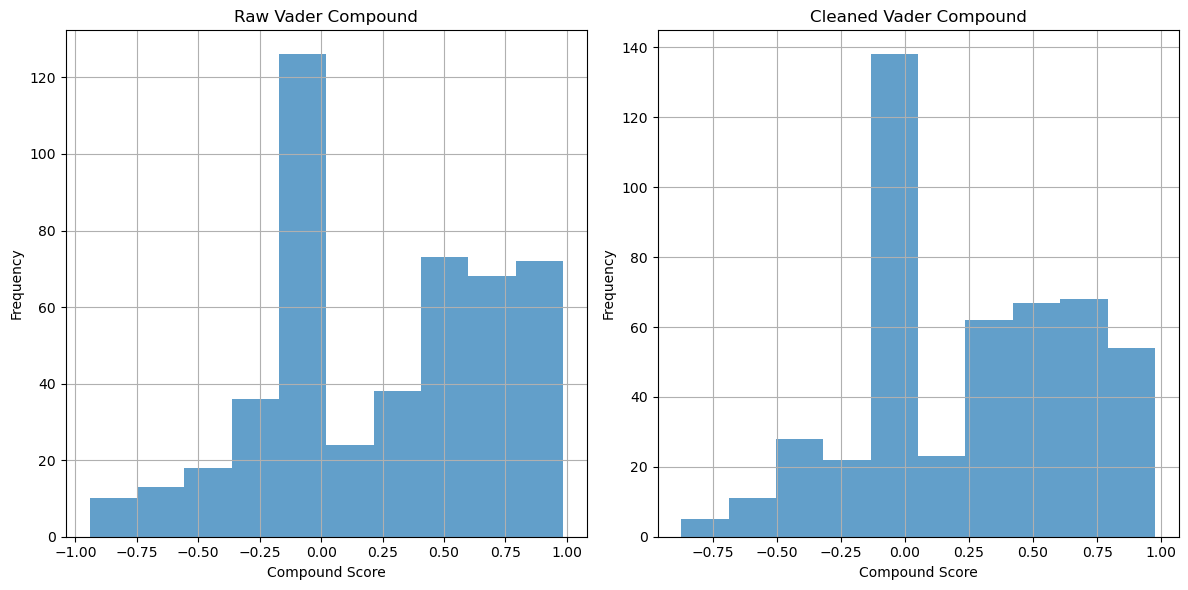

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot histogram for raw_vader_compound
plt.subplot(1, 2, 1)
vader_test_df['raw_vader_compound'].hist(bins=10, alpha=0.7)
plt.title('Raw Vader Compound')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')

# Plot histogram for cleaned_vader_compound
plt.subplot(1, 2, 2)
vader_test_df['cleaned_vader_compound'].hist(bins=10, alpha=0.7)
plt.title('Cleaned Vader Compound')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### 1.2. Sentiment Dictionary Assessment
For this, the following class will is intended to standardize the comparison metrics we will implement for each of the developed models.

In [58]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

class ClassificationEvaluator:
    def __init__(self, true_labels, predicted_labels, cutoff=0.5, model_name="Model"):
        self.true_labels = true_labels
        self.predicted_labels = predicted_labels
        self.cutoff = cutoff
        self.model_name = model_name
        self.predicted_int = (self.predicted_labels >= self.cutoff).astype("int32")
        
    def evaluate(self):
        """
        To provide a classification report that includes:
        precision, recall, f1-score, and support for each class.
        """
        print('Classification report:\n')
        print(classification_report(self.true_labels, self.predicted_int))

#⚠️⚠️⚠️⚠️        
    def plot_confusion_matrix(self):
        """
        To visually represent the performance of the classifier, 
        using a confusion matrix.
        """
        cm = confusion_matrix(self.true_labels, self.predicted_int)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                    xticklabels=['Negative (0)', 'Positive (1)'], 
                    yticklabels=['Negative (0)', 'Positive (1)'])
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.show()
        print (cm)

    def plot_roc_auc(self):
        """
        To evaluate the model's performance across different classification
        thresholds using the ROC curve and the Area Under the Curve (AUC)
        """
        fpr, tpr, _ = roc_curve(self.true_labels, self.predicted_int)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(4, 3))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
        
        print(f'AUC: {roc_auc:.2f}')
        
        return roc_auc

    def save_metrics(self, df_scores=None):
        """
        Calculate evaluation metrics, and add them to a DataFrame for further comparison.
        """
        acc = accuracy_score(self.true_labels, self.predicted_int)
        auc_value = self.plot_roc_auc()
        report = classification_report(self.true_labels, self.predicted_int, output_dict=True)
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']
        f1 = report['weighted avg']['f1-score']
        
        metrics = {
            'Accuracy': acc,
            'AUC': auc_value,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1
        }
        
        if df_scores is None:
            df_scores = pd.DataFrame()
    
        model_name = self.model_name
        counter = 1

            # Ensure the model name is unique
        while model_name in df_scores.columns:
            model_name = f"{self.model_name}_{counter}"
            counter += 1

        df_scores[model_name] = pd.Series(metrics)
        
        return df_scores

Now that we have the standard evaluator built we can use it to compare both vaderSentiment predictions.

Classification report:

              precision    recall  f1-score   support

       False       0.45      0.42      0.43        96
        True       0.86      0.87      0.87       382

    accuracy                           0.78       478
   macro avg       0.66      0.65      0.65       478
weighted avg       0.78      0.78      0.78       478



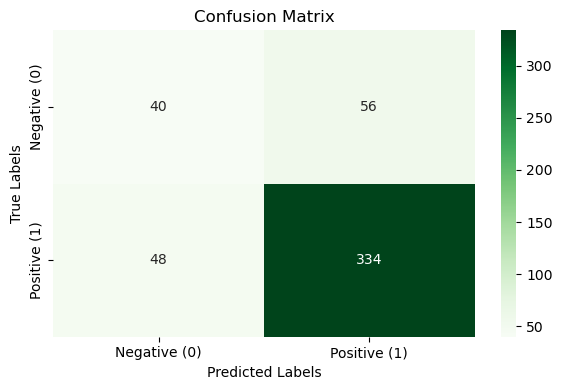

[[ 40  56]
 [ 48 334]]


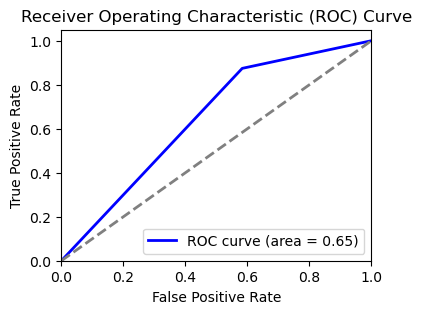

AUC: 0.65


In [90]:
# Initializing the performance evaluator class for vader
raw_vader_performance_evaluator = ClassificationEvaluator(true_labels=vader_test_df['sentiment'], 
                                                          predicted_labels=vader_test_df['raw_vader_label'],
                                                          model_name = 'Raw Text VaderSerntiment')
# Applying the class to the raw text predictions
raw_vader_performance_evaluator.evaluate()
raw_vader_performance_evaluator.plot_confusion_matrix()
df_scores = raw_vader_performance_evaluator.save_metrics(df_scores=df_scores)

Classification report:

              precision    recall  f1-score   support

       False       0.54      0.42      0.47        96
        True       0.86      0.91      0.89       382

    accuracy                           0.81       478
   macro avg       0.70      0.66      0.68       478
weighted avg       0.80      0.81      0.80       478



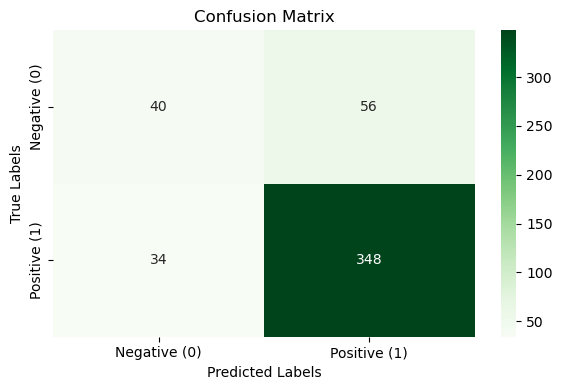

[[ 40  56]
 [ 34 348]]


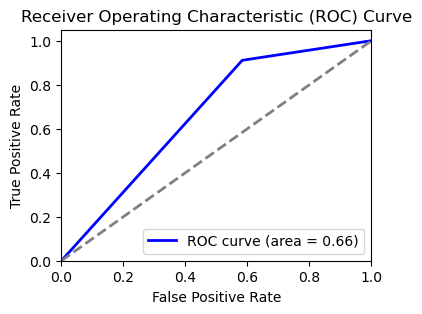

AUC: 0.66


In [92]:
# Initializing the performance evaluator class for vader
clean_vader_performance_evaluator = ClassificationEvaluator(true_labels=vader_test_df['sentiment'], 
                                                            predicted_labels=vader_test_df['cleaned_vader_label'],
                                                            model_name = 'Cleaned Text VaderSerntiment')

# Applying the class to the clean text predictions
clean_vader_performance_evaluator.evaluate()
clean_vader_performance_evaluator.plot_confusion_matrix()
df_scores = clean_vader_performance_evaluator.save_metrics(df_scores=df_scores)

🔷 Argumentation of: <br>
Why we used these metrics <br>
Why weighted average is important to use on the last row of the report <br>
🔷 Explanation of the results, what do them imply? <br>
check #https://github.com/Humboldt-WI/delta/blob/master/demos/nlp/sentiment_analysis.ipynb <br>
Some ideas: <br>
- It can be not the most suitable thing to emply as the it assigns polarity scores including 0 which is neutral, whereas or real labels don't have a neutral value. That's why we tried finding the perfect threshold.
- It's a simple/ straightforward method to apply sentiment analysis.

## 2. RNN-based Language Classifier

In [66]:
# Copy database for this implementation
rnn_train_df = cleaned_train_df.copy()
rnn_test_df = cleaned_test_df.copy()

### 2.1. Text data representation / Embedding: FastText

In [68]:
from gensim.models import FastText

# Tokenize the cleaned tweets (split by spaces)
tokenized_tweets_FT = [tweet.split() for tweet in rnn_train_df['cleaned_content']]

# Train FastText model using Gensim's implementation
fasttext_model = FastText(sentences=tokenized_tweets_FT, vector_size=50, window=5, min_count=1, sg=0, epochs=10)

🔷 Argumentation of why we set the parameters like that. Explanation in notion

In [70]:
# Getting to know the vocabulary from FastText
# Number of words in the vocabulary
vocab_size = len(fasttext_model.wv)
print(f"Number of words in the vocabulary: {vocab_size}")

# Words and their counts
word_counts = {word: fasttext_model.wv.get_vecattr(word, "count") for word in fasttext_model.wv.index_to_key}

# Top 5 most frequent words
top_5_words = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)[:5]
print("Top 5 words and their occurrences:")
for word, count in top_5_words:
    print(f"{word}: {count}")

Number of words in the vocabulary: 6469
Top 5 words and their occurrences:
bitcoin: 1098
$: 1010
btc: 787
crypto: 351
eth: 230


In [72]:
# See the vector for a specific word 
word_info = 'bitcoin' 
print(f"Vector for '{word_info}':\n: {fasttext_model.wv[word_info]}")

# Get most similar words
print(f"Words similar to '{word_info}':\n: {fasttext_model.wv.most_similar(word_info)}")

Vector for 'bitcoin':
: [-0.54739916  0.7788048   0.30015942 -0.68277836  0.14310648 -0.1609972
 -0.7250386   1.7351693  -1.439743    0.04286345  1.0373461   0.379554
 -0.0685459  -1.8438548  -0.22827509  1.3895228   1.3553855  -0.7602605
 -0.68212545 -1.0233152   0.8678977   0.68799967  0.29149434  1.6027989
  0.7800074   0.852477   -1.5716739  -0.8492202  -2.0859823   0.96201086
  3.41637     0.26919156 -0.78513056  2.619744    1.0826886   0.08952472
 -0.6600567   0.5772431   0.8660143  -0.22426811  0.26289424  1.047849
 -0.81738806  1.0148838  -0.54678005 -1.8143467   1.1387802  -0.6752972
 -0.7895217   2.3131075 ]
Words similar to 'bitcoin':
: [('bitcoinnews', 0.9999979734420776), ('bitcoinfrogs', 0.9999974966049194), ('antibitcoin', 0.9999971389770508), ('bitcoinnft', 0.9999969601631165), ('bitcoincows', 0.9999966621398926), ('bitcoinnfts', 0.9999964237213135), ('bitcoindeepa', 0.9999964237213135), ('freebitcoin', 0.9999964237213135), ('bitcoinbaytpa', 0.9999963641166687), ('swanb

### 2.2. Vocabulary building with keras

In [74]:
# ⚠️ Check if we used all imported libraries 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.regularizers import l2

In [76]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the text
keras_tokenizer = Tokenizer(num_words=vocab_size, oov_token='OOV')
# The oov_token is a placeholder token that replaces any OOV words during the text_to_sequence calls.
# This ensures that the model can handle new, unseen words gracefully.
keras_tokenizer.fit_on_texts(rnn_train_df['cleaned_content'])

🔷🔷 Argument the selecter parameters and remove comment

In [78]:
# Getting to know the vocabulary from Keras 
# Check the vector dimensions using it with Keras
vector_dim = fasttext_model.wv.vector_size
print(f"Dimension of word vectors: {vector_dim}")

# Number of words in the vocabulary
print("Number of unique words:", len(keras_tokenizer.word_counts))

# Top 5 most frequent words
top_n_words = sorted(keras_tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 most frequent words:")
for word, count in top_n_words:
    print(f"{word}: {count}")

Dimension of word vectors: 50
Number of unique words: 6468
Top 5 most frequent words:
bitcoin: 1098
btc: 787
crypto: 351
eth: 230
amp: 164


In [80]:
# See the vector for a specific word
word_info = 'bitcoin'
n = keras_tokenizer.word_docs[word_info]
print('The word <{}> appeared in {} tweets.'.format(word_info, n))

The word <bitcoin> appeared in 981 tweets.


🔷🔷🔷 In this case, we can see that in the Keras Model, there is no token assigned for the character '$',...
I believe this is handled by the OVV parameter

In [82]:
# Data partitioning for validation set
rnn_X_train, rnn_X_val, rnn_y_train, rnn_y_val = train_test_split(rnn_train_df['cleaned_content'],rnn_train_df['sentiment'], test_size = 0.2, random_state = 5)
rnn_X_train.shape, rnn_X_val.shape, rnn_y_train.shape, rnn_y_val.shape
# Convert each text into a sequence of integers,
# where each integer represents a specific word in the tokenizer's vocabulary.
# Based on the X_train's 'fit_on_texts'
X_train_seq = keras_tokenizer.texts_to_sequences(rnn_X_train)
X_val_seq = keras_tokenizer.texts_to_sequences(rnn_X_val)
X_test_seq = keras_tokenizer.texts_to_sequences(rnn_test_df['cleaned_content'])

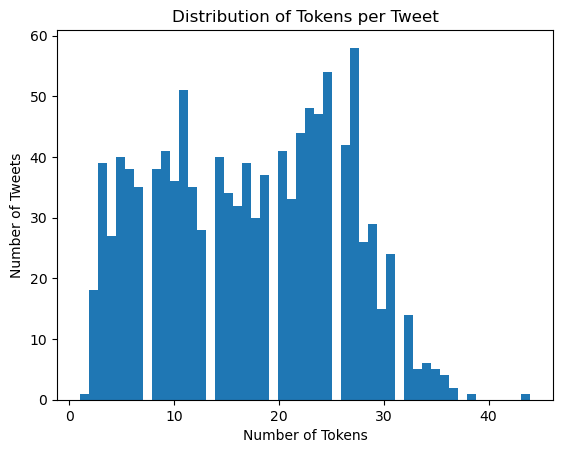

In [84]:
import matplotlib.pyplot as plt

# Calculate the number of tokens per tweet
tokens_per_tweet = [len(seq) for seq in X_train_seq]

# Plot the distribution
plt.hist(tokens_per_tweet, bins=50)
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Tokens per Tweet')
plt.show()

In [86]:
# Pad the sequences
max_length = 40 # Set max length for padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

🔷 Since each tweet is considerably small in lenght, it makes sense to include all the pads to get all the context possible

### 2.3. Using Pre-trained Embeddings from FastText
In order to leverage the FastText embeddings we previously generated, we create an Embedding layer in Keras that uses the FastText embeddings:

In [88]:
# Create an embedding matrix
embedding_dim = fasttext_model.wv.vector_size
vocab_size = len(keras_tokenizer.word_index)   # It's the total number of unique words in the tokenizer’s vocabulary plus one. 
embedding_matrix  = fasttext_model.wv.vectors 

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (6469, 50)


🔷❌ "As we can see, the shape matches our requirements" or something like that. We need to argument this well.

### 2.4. RNN Model

In [96]:
# Changing the dtype from series to array
rnn_y_train = rnn_y_train.to_numpy()
rnn_y_val = rnn_y_val.to_numpy()

In [100]:
import numpy as np
# Calculate the class weights to handle dataframe imbalance
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(rnn_y_train), y=rnn_y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 2.5863636363636364, 1: 0.6198257080610022}

🔷 Since 0 is the minority class then that's why is higher

In [102]:
# Define the RNN model with Keras
RNN_model = Sequential()
RNN_model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_dim, 
                        weights=[embedding_matrix], 
                        input_length=max_length,
                        trainable=False))
# Play with parameters
#model.add(LSTM(units = 64, return_sequences = False, kernel_regularizer=l2(0.02)))
RNN_model.add(LSTM(164, return_sequences=False, kernel_regularizer=l2(0.02)))
RNN_model.add(Dropout(0.2))
RNN_model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.02)))
RNN_model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')
RNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 50)            323450    
                                                                 
 lstm (LSTM)                 (None, 164)               141040    
                                                                 
 dropout (Dropout)           (None, 164)               0         
                                                                 
 dense (Dense)               (None, 1)                 165       
                                                                 
Total params: 464,655
Trainable params: 141,205
Non-trainable params: 323,450
_________________________________________________________________


In [108]:
#Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = RNN_model.fit(X_train_pad, rnn_y_train, epochs=20, batch_size=32, validation_data=(X_val_pad, rnn_y_val), class_weight=class_weights, callbacks=[early_stop])
#⚠️Check if there's an argument to pass the weights. For 1 and 0, how many times are going to be outweighted
# ⚠️We should add a stop callbacks in case the accuracy doesn't improve in like two epochs

Epoch 1/20
36/36 [==============================] - 4s 41ms/step - loss: 1.9989 - accuracy: 0.4833 - val_loss: 1.3634 - val_accuracy: 0.8000
Epoch 2/20
36/36 [==============================] - 1s 23ms/step - loss: 1.2071 - accuracy: 0.4710 - val_loss: 0.9043 - val_accuracy: 0.8000
Epoch 3/20
36/36 [==============================] - 1s 25ms/step - loss: 0.9279 - accuracy: 0.5492 - val_loss: 0.8177 - val_accuracy: 0.8000
Epoch 4/20
36/36 [==============================] - 1s 24ms/step - loss: 0.8356 - accuracy: 0.4244 - val_loss: 0.8083 - val_accuracy: 0.2000
Epoch 5/20
36/36 [==============================] - 1s 34ms/step - loss: 0.7795 - accuracy: 0.5466 - val_loss: 0.7026 - val_accuracy: 0.8000
Epoch 6/20
36/36 [==============================] - 1s 29ms/step - loss: 0.7616 - accuracy: 0.5518 - val_loss: 0.7166 - val_accuracy: 0.8000
Epoch 7/20
36/36 [==============================] - 1s 31ms/step - loss: 0.7443 - accuracy: 0.4016 - val_loss: 0.6780 - val_accuracy: 0.8000
Epoch 8/20
36

### 2.5. Evaluate RNN

In [112]:
# Evaluate the model on the test set
loss, accuracy = RNN_model.evaluate(X_val_pad, rnn_y_val)
print(f"Test Accuracy: {accuracy}")

# Predict on test data
rnn_y_pred = RNN_model.predict(X_test_pad)
rnn_y_pred_int = (rnn_y_pred > 0.5).astype("int32")

9/9 [==============================] - 0s 7ms/step - loss: 0.6780 - accuracy: 0.8000
Test Accuracy: 0.800000011920929
15/15 [==============================] - 1s 8ms/step


Classification report:

              precision    recall  f1-score   support

       False       0.00      0.00      0.00        96
        True       0.80      1.00      0.89       382

    accuracy                           0.80       478
   macro avg       0.40      0.50      0.44       478
weighted avg       0.64      0.80      0.71       478



C:\Users\Sebastian\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sebastian\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sebastian\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


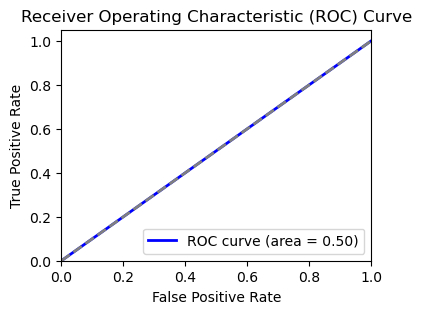

AUC: 0.50


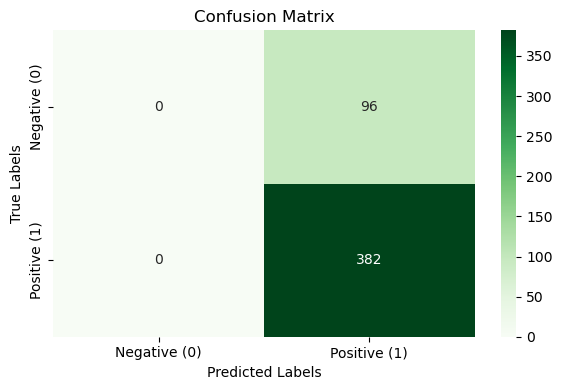

[[  0  96]
 [  0 382]]


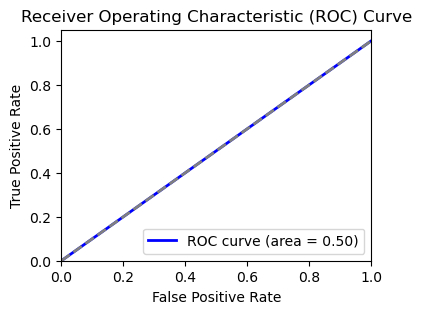

AUC: 0.50


C:\Users\Sebastian\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sebastian\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Sebastian\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [114]:
RNN_performance_evaluator = ClassificationEvaluator(true_labels=rnn_test_df['sentiment'], 
                                                    predicted_labels= rnn_y_pred,
                                                    cutoff = 0.5,
                                                    model_name = 'RNN')

# Applying the class to the raw text predictions
RNN_performance_evaluator.evaluate()
RNN_performance_evaluator.plot_roc_auc()
RNN_performance_evaluator.plot_confusion_matrix()
df_scores = RNN_performance_evaluator.save_metrics(df_scores=df_scores)

🔷⚠️ Fill interpretation on what's going on <br>
Maybe try to change hyperparameters 
+ Regularization

## 3. Pre-trained DistilBERT

### 3.1. Model initializing

In [116]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

# Load the pre-trained model and tokenizer from Hugging Face
tokenizer_PT_DTB = AutoTokenizer.from_pretrained("DT12the/distilbert-sentiment-analysis")
PT_DTB_model = AutoModelForSequenceClassification.from_pretrained("DT12the/distilbert-sentiment-analysis")

In [118]:
DTB_test_df = cleaned_test_df.copy()

In [143]:
# Since the model is pre-trained and fine-tuned for sentiment analysis, we don't need to train it further on the data.
# We are only using this model to make predictions on the test (or validation) set, thus we tokenize it.
tokens_val_PT_DTB = tokenizer_PT_DTB(
    list(DTB_test_df['cleaned_content']),
    padding=True,
    truncation=True,
    max_length=40,  # ⚠️ Adjust this if your sequences are longer or shorter, and explain why we did it that way
    return_tensors='pt'
)

In [145]:
# Make predictions on the test set
with torch.no_grad():
    outputs_PT_DTB = PT_DTB_model(**tokens_val_PT_DTB)

# Get predicted class labels
predictions_PT_DTB = torch.argmax(outputs_PT_DTB.logits, dim=1)

# Convert predictions to NumPy array for comparison
predictions_PT_DTB = predictions_PT_DTB.numpy()

### 3.2. Model evaluation

Classification report:

              precision    recall  f1-score   support

       False       0.14      0.60      0.22        96
        True       0.31      0.04      0.08       382

    accuracy                           0.16       478
   macro avg       0.22      0.32      0.15       478
weighted avg       0.27      0.16      0.11       478



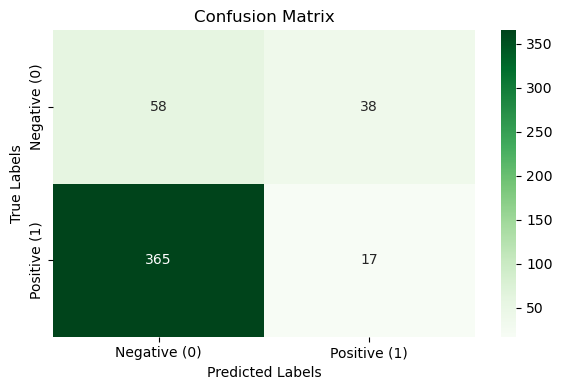

[[ 58  38]
 [365  17]]


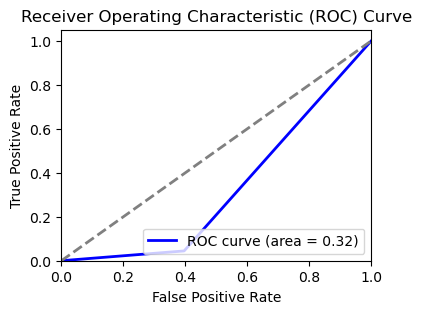

AUC: 0.32


In [151]:
# Evaluate the model
PT_DistilBERT_performance_evaluator = ClassificationEvaluator(true_labels=DTB_test_df['sentiment'], 
                                                            predicted_labels=predictions_PT_DTB,
                                                            model_name='Pre-Trained DistilBERT')
PT_DistilBERT_performance_evaluator.evaluate()
PT_DistilBERT_performance_evaluator.plot_confusion_matrix()
df_scores = PT_DistilBERT_performance_evaluator.save_metrics(df_scores=df_scores)

## 4. Fine-tuned DistilBERT

### 4.2. Model initializing

In [156]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainingArguments,  Trainer

# Load the tokenizer and model
tokenizer_DTB = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
DTB_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

# Alternatively, use a pipeline for easier handling
sentiment_analysis = pipeline("sentiment-analysis", model=DTB_model, tokenizer=tokenizer_DTB)

In [196]:
# Database copy
DTB_train_df = cleaned_train_df.copy()
DTB_test_df = cleaned_test_df.copy()
# Data partitioning for validation set
DTB_X_train, DTB_X_val, DTB_y_train, DTB_y_val = train_test_split(DTB_train_df['cleaned_content'],DTB_train_df['sentiment'], test_size = 0.2, random_state = 5)

In [198]:
# Tokenize the training and validation set
tokens_train = tokenizer_DTB(
    list(DTB_X_train),
    padding=True,
    truncation=True,
    max_length=40,  # Adjust this according to your sequence lengths
    return_tensors='pt'
)

tokens_val = tokenizer_DTB(
    list(DTB_X_val),
    padding=True,
    truncation=True,
    max_length=40,  # ⚠️ Adjust this if your sequences are longer or shorter, and explain why we did it that way
    return_tensors='pt'
)

tokens_test = tokenizer_DTB(
    list(DTB_test_df['cleaned_content']),
    padding=True,
    truncation=True,
    max_length=40,  # ⚠️ Adjust this if your sequences are longer or shorter, and explain why we did it that way
    return_tensors='pt'
)

# Convert the labels to a tensor
labels_train = torch.tensor(list(map(int, DTB_y_train.values)), dtype=torch.long)
labels_val = torch.tensor(list(map(int, DTB_y_val.values)), dtype=torch.long)
labels_test = torch.tensor(list(map(int, DTB_test_df['sentiment'].values)), dtype=torch.long)

In [189]:
# Define a dataset class (optional, for clarity)
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [191]:
##### Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)
# Define training and evaluation datasets
train_dataset = SentimentDataset(tokens_train, labels_train)
val_dataset = SentimentDataset(tokens_val, labels_val)   

# Train DistilBERT model
trainer = Trainer(
    model=DTB_model,                 # the instantiated 🤗 Transformers model to be trained
    args=training_args,              # training arguments, defined above
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_34488\1103402027.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_34488\1103402027.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Step,Training Loss
10,0.425600
20,0.433900
30,0.276500
40,0.468800
50,0.237900
60,0.350000
70,0.388200


TrainOutput(global_step=72, training_loss=0.38032195965449017, metrics={'train_runtime': 63.0694, 'train_samples_per_second': 18.044, 'train_steps_per_second': 1.142, 'total_flos': 11777179661760.0, 'train_loss': 0.38032195965449017, 'epoch': 1.0})

In [200]:
# Evaluate model on the test set
# Disable gradient calculation for evaluation
with torch.no_grad():
    outputs_DTB = DTB_model(**tokens_test)

# Get the predicted class (0 or 1)
predictions_DTB = torch.argmax(outputs_DTB.logits, dim=1)

# Convert predictions to NumPy array for comparison
predictions_DTB = predictions_DTB.numpy()

### 4.2. Model Evaluation

Classification report:

              precision    recall  f1-score   support

       False       0.82      0.60      0.69        96
        True       0.91      0.97      0.94       382

    accuracy                           0.89       478
   macro avg       0.86      0.79      0.81       478
weighted avg       0.89      0.89      0.89       478



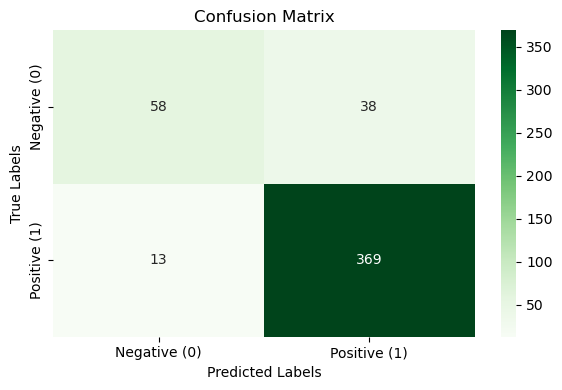

[[ 58  38]
 [ 13 369]]


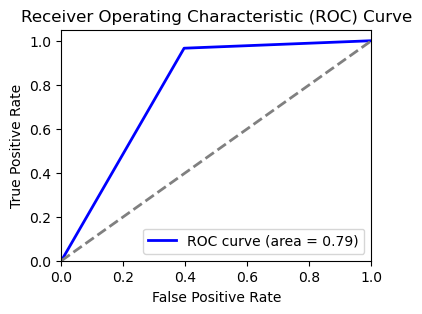

AUC: 0.79


In [202]:
# Evaluate the model
FT_DistilBERT_performance_evaluator = ClassificationEvaluator(true_labels=DTB_test_df['sentiment'], 
                                                            predicted_labels=predictions_DTB,
                                                            model_name='Fine-tuned DistilBERT')
FT_DistilBERT_performance_evaluator.evaluate()
FT_DistilBERT_performance_evaluator.plot_confusion_matrix()
df_scores = FT_DistilBERT_performance_evaluator.save_metrics(df_scores=df_scores)

🔷 If we were to run more epochs (like 3, the performance metrics would improve)

## Models comparison

See https://github.com/Humboldt-WI/delta/blob/master/demos/nlp/sentiment_analysis.ipynb <br>
Create a container in which we store the results of different models. Good options are either a dictionary or a data set. In this notebook, we use the latter approach. To ensure comparability across different approaches, we will re-calculate the performance of the lexicon-based model for the observations of the test set.

Before that, we need to clean our test set

In [99]:
# Cleaned content check
ix = 1  # Enter one entry number to further examine the effect of the text cleaning process
print('Original Review:\n' + cleaned_test_df.content[ix])  
print('\nCleaned Review:\n' + cleaned_test_df.cleaned_content[ix])

Original Review:
#Bitcoin would have to fall another 80% to reach the lows of 3 years ago.

Rates have already skyrocketed, most crypto platforms (including FTX) died, and sentiment is dead as most think it’s over.

Even if #Bitcoin falls 50% to $14k new lows (which I doubt), this is remarkable.

Cleaned Review:
bitcoin would fall another reach low year ago rate already skyrocketed crypto platform including ftx died sentiment dead think even bitcoin fall k new low doubt remarkable


### Vader Sentiment

In [113]:
# Apply the same sentiment analysis we used for the train dataset to the test dataset
cleaned_test_df['vader_sentiment'] = cleaned_test_df['cleaned_content'].apply(analyze_sentiment)
# Extract compound score for simplicity
cleaned_test_df['vader_compound'] = cleaned_test_df['vader_sentiment'].apply(lambda x: x['compound'])
# Convert compound score to sentiment label
cleaned_test_df['vader_label'] = cleaned_test_df['vader_compound'].apply(compound_to_binary_sentiment)

In [129]:
if 'sentiment' in cleaned_test_df.columns:
    
    accuracy = accuracy_score(cleaned_test_df['sentiment'], cleaned_test_df['vader_label'])
    precision = precision_score(cleaned_test_df['sentiment'], cleaned_test_df['vader_label'], average='weighted')
    recall = recall_score(cleaned_test_df['sentiment'], cleaned_test_df['vader_label'], average='weighted')
    f1 = f1_score(cleaned_test_df['sentiment'], cleaned_test_df['vader_label'], average='weighted')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")

Accuracy: 0.7789473684210526
Precision: 0.7729718135940654
Recall: 0.7789473684210526
F1-score: 0.7757766435165815


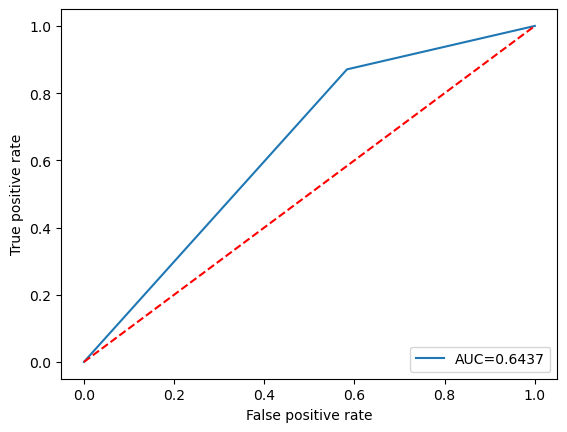

In [131]:
# Assess vaderSentiment on testset
auc, acc, cmat = assess_sentiment_classifier(ytest=cleaned_test_df['sentiment'], yhat=cleaned_test_df['vader_label'], cut_off=0)

### RNN

In [ ]:
# Run model on test data
y_test_pred = RNN_model.predict(X_val_pad)
y_pred = (y_pred > 0.5).astype("int32")

from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

### Pre-trained DistilBERT

In [142]:
cleaned_test_df.head(3)

,content,username,sentiment,cleaned_content,vader_sentiment,vader_compound,vader_label
0,"#crypto $crypto #btc \nI am Chinese crypto alpha, although my English is not good, but I will try to send some English tweets! Let me see if there are messages of support from foreign fans！",huahuayjy,True,crypto crypto btc chinese crypto alpha although english good try send english tweet let see message support foreign fan,"{'neg': 0.0, 'neu': 0.669, 'pos': 0.331, 'compound': 0.7845}",0.7845,1
1,"#Bitcoin would have to fall another 80% to reach the lows of 3 years ago.\n\nRates have already skyrocketed, most crypto platforms (including FTX) died, and sentiment is dead as most think it’s over.\n\nEven if #Bitcoin falls 50% to $14k new lows (which I doubt), this is remarkable.",luke_broyles,False,bitcoin would fall another reach low year ago rate already skyrocketed crypto platform including ftx died sentiment dead think even bitcoin fall k new low doubt remarkable,"{'neg': 0.372, 'neu': 0.509, 'pos': 0.12, 'compound': -0.872}",-0.8720,0
2,#Giveaway $1000 Matic in 3Days\n\n🏆To win\n1️⃣ Follow @matic\n2️⃣ Like &amp; RT\n3️⃣ Tag 3 Friends \n\n#BTC #SolanaGiveaways #Giveaway #Airdrop #Matic #Ripple #GiveawayAlert https://t.co/ysklxXKPbM,cryptomarsdo,True,giveaway matic day trophy win keycap follow matic keycap like amp rt keycap tag friend btc solanagiveaways giveaway airdrop matic ripple giveawayalert,"{'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'compound': 0.8591}",0.8591,1


In [ ]:
# Tokenize
tokens_test_PT_DTB = tokenizer_PT_DTB(
    list(cleaned_test_df['cleaned_content']),
    padding=True,
    truncation=True,
    max_length=40,  # ⚠️ Adjust this if your sequences are longer or shorter, and explain why we did it that way
    return_tensors='pt'
)
# Make predictions on the validation set
with torch.no_grad():
    outputs_val_PT_DTB = PT_DTB_model(**tokens_test_PT_DTB)

# Get predicted class labels
predictions_PT_DTB = torch.argmax(outputs_val_PT_DTB.logits, dim=1)

# Convert predictions to NumPy array for comparison
predictions_PT_DTB = predictions_PT_DTB.numpy()

# Evaluate the model
print(classification_report(y_val, predictions_PT_DTB))

### Fine-tuned DistilBERT